In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Config')
from lablib import *

# Definizione funzioni

In [2]:
#Per la sezione di polarizzazione

def Malus_cmp_el(alfa, I0):
    return np.sqrt(I0)*(np.cos(alfa))

def Malus_onde_piane(alfa, I0):
    return I0*np.cos(alfa)**2

def Malus_onde_sferiche(alfa, I0, d):
    return (I0*(np.cos(alfa)/d)**2)

def Malus_combo(alfa, I0, A, B, C, D):
    return A*I0**C*np.cos(alfa)**2 + B*I0**D*np.cos(alfa)

def Malus_disperazione(alfa, I0, A, B, C):
    return A*I0*(np.cos(alfa))**2 + B*I0*(np.cos(alfa))**2 + C*I0*(np.cos(alfa))**2

#Sono da inserire di seguito le funzioni per fit dell'esperienza di polarizzazione
#Sono le funzioni al variare di theta e r 

#Per Brewster bisogna utilizzare un'iterpolazione parabolica
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

def parabola_shift(x, a, b):
    return -(x-b)**2 + a

#Per la sezione di interferenza dobbiamo scegliere due esperienza diverse. 
#Riporto comunque le funzioni per tutte e quattro

# #1 Per la sezione di interferenza con la doppia fenditura
# #massimi sono a: d*sin(theta) = n*lambda. Voglio ottenere theta
# def double_slit_max(n, d, l):
#     return np.arcsin(n*l/d)
    
# #minimi sono a: d*sin(theta) = (n/2)*lambda. Voglio ottenere theta
# def double_slit_min(n, d, l):
#     return np.arcsin(n*l/(2*d))


#2 Per la sezione di interferenza con specchio di LLoyd

#voglio ottenere n, sapendo che abbiamo misurato dei minimi
def lloyd_n_frangia(d, h):
    return int((2*h + 4*np.sqrt((d/2)**2 + h**2))/2.85)

#voglio ottenere solo lambda
def lloyd(d, h, n):
    return (2*h + 4*np.sqrt((d/2)**2 + h**2))/n

# #3 Per la sezione di interferenza con cavità di Fabry-Perot

# #voglio ottenere distanza tra i due schermi semiriflettenti
# def fabry_perot(l, m):
#     return m*l/2

#4 Per la sezione di interferenza con Michelson

#voglio ottenere lambda. N è il numero di frange contate nello spostamento x dello specchio
def michelson(N, x):
    return 2*x/N

# Per la sezione di diffrazione alla Bragg

#Il massimo si ha per 2*d*sin(theta) = n*lambda. Voglio ottenere d
def braggs(l, n, theta):
    return l/(2*np.sin(theta))

# Import dati

# POLARIZZAZIONE

**NOTA!!!**\
ricordiamoci dell'errore sulle x

Le misure degli angoli sono prese in gradi \
Le misure di intensità sono prese in volt \
Sensibilità goniometro = 5 gradi \
Sensibilità amperometro = 0.01 volt  \
Oscillazione amperometro = 0.05 \
Errore sistematico nel goniometro: non è possibile fare in modo che siano sempre dritti \
Tentiamo d prendere le misure con sempre la stessa inclinazione. \
Distanza tra i ricevitori (da dritti) = 50cm

In [3]:
dati_polatizzazione = pd.read_excel("dati_pol.xlsx")
rad_malus = np.deg2rad(dati_polatizzazione["gradi"])
amp_malus = dati_polatizzazione["tensione"]
amp_malus_err = [0.05]*len(amp_malus)
dist_malus = .5

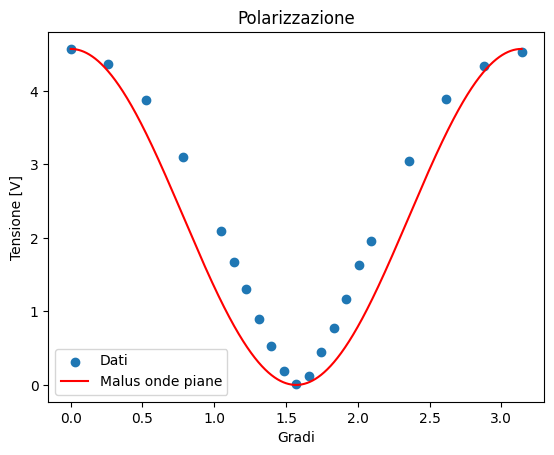

In [4]:
t1 = np.linspace(min(rad_malus), max(rad_malus), 100000)
plt.scatter(rad_malus, amp_malus, label="Dati", marker="o")
plt.plot(t1, Malus_onde_piane(t1, max(amp_malus)), label="Malus onde piane", color="red")
#plt.plot(t1, Malus_onde_sferiche(t1, max(amp_malus), dist_malus), label="Malus onde sferiche", color="green")
#plt.plot(t1, Malus_cmp_el(t1, max(amp_malus)), label="", color="blue")
plt.xlabel("Gradi")
plt.ylabel("Tensione [V]")
plt.title("Polarizzazione")
plt.legend()
plt.show()

In [5]:
#fit Malus disperazione

def func_disp(alfa, A, B, C):
    return Malus_disperazione(alfa, max(amp_malus), A, B, C)

def func_combo(alfa, A, B, C, D):
    return Malus_combo(alfa, max(amp_malus), A, B, C, D)

pars_malus_d, vals_malus_d, ers_malus_d, *other_malus_d = LS_fit(rad_malus, amp_malus, amp_malus_err, func_disp, A=1, B=1, C=1)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2123 (χ²/ndof = 117.9)     │              Nfcn = 53               │
│ EDM = 1.15e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   0.37    │   0.07    │            │            │         │         │       │
│ 1 │ B    │   0.37    │   0.07    │            │            │         │         │       │
│ 2 │ C    │   0.37    │   0.07    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       A       B       C │
├───┼─────────────────────────┤
│ A │ 0.00476  -0.002  -0.002 │
│ B │  -0.002 0.00476  -0.002 │
│ C │  -0.002  -0.002 0.00476 │
└───┴─────────────────────────┘

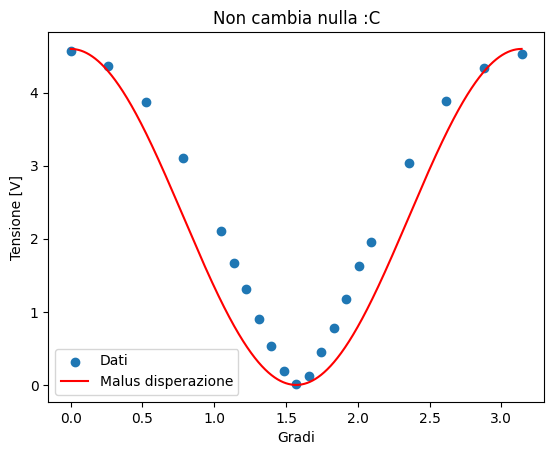

Parametro a: 2.002080455349056 +- 0.02187990767812867
Parametro b: 1.0020804556072727 +- 0.021879907614030112
Parametro c: -1.9979195445748297 +- 0.02187991005023148


In [6]:
# fit manuale per fissare i dati - non ho idea di come funzioni
# di base crea una funzione di costo personalizzata

x_fixed_points = [t1[0], t1[-1]]
y_fixed_values = [amp_malus[0], amp_malus[len(amp_malus)-1]]
penalty_weight = 10000  # Peso della penalità per fissare i punti

def chi_squared(a, b, c):
    model = func_disp

    y_model = model(rad_malus, a, b, c)
    chi2 = np.sum(((amp_malus - y_model) / amp_malus_err) ** 2)
    for x_fixed, y_fixed in zip(x_fixed_points, y_fixed_values):
        y_model_fixed = model(x_fixed, a, b, c)
        chi2 += penalty_weight * (y_model_fixed - y_fixed) ** 2
    return chi2

# Inizializzazione del fit
m_malus = Minuit(chi_squared, a=5, b=4, c=1)
m_malus.errordef = Minuit.LEAST_SQUARES
m_malus.migrad()
val_fit = m_malus.values[:3]

# plot dei risultati

plt.scatter(rad_malus, amp_malus, label="Dati", marker="o")
plt.plot(t1, Malus_disperazione(t1, max(amp_malus), *val_fit), label="Malus disperazione", color="red")
plt.xlabel("Gradi")
plt.ylabel("Tensione [V]")
plt.title("Non cambia nulla :C")
plt.legend()
plt.show()

for i in range(len(val_fit)):
    print(f"Parametro {m_malus.parameters[i]}: {val_fit[i]} +- {m_malus.errors[i]}")


Provare a eseguire il fit con questa
![alt text](image.png)

# AMPIEZZA

## Rotazione

In [7]:
dati_rotazione = pd.read_excel("dati_rotazione.xlsx")
rad_rotaz_prec = np.deg2rad(dati_rotazione["gradi_precisi"])
amp_rotaz = dati_rotazione["tensione_precisa"]
amp_rotaz_err = [0.05 for _ in amp_rotaz]

In [8]:
# fit per stabilire la potenza del coseno

def func_rot(alfa, A):
    return max(amp_rotaz)*np.cos(alfa)**A

pars_rot, vals_rot, ers_rot, *other_rot = LS_fit(rad_rotaz_prec, amp_rotaz, amp_rotaz_err, func_rot, A=1, disp=0)

print(f"Va circa come un coseno alla {vals_rot[0]:.3g} +- {ers_rot[0]:.3g} potenza")

Va circa come un coseno alla 8.38 +- 0.148 potenza


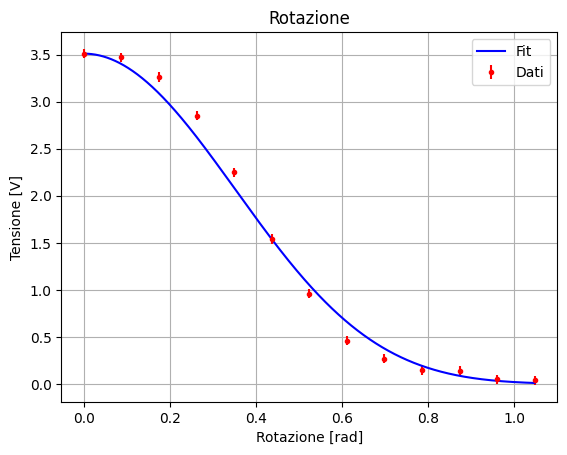

In [9]:
t2 = np.linspace(min(rad_rotaz_prec), max(rad_rotaz_prec), 100000)

plt.errorbar(rad_rotaz_prec, amp_rotaz, amp_rotaz_err, fmt=".r", label="Dati")
plt.plot(t2, func_rot(t2, *vals_rot), label="Fit", color="blue")
plt.xlabel("Rotazione [rad]")
plt.ylabel("Tensione [V]")
plt.title("Rotazione")
plt.legend()
plt.grid()
plt.show()

**Commenti**

* La dipendenza dell'intensità da $cos^8(\theta)$  suggerisce che l'emettitore produce un fascio altamente direzionale. In altre parole, l'emissione è fortemente concentrata lungo un asse specifico e l'intensità diminuisce rapidamente con l'aumentare dell'angolo $\theta$ rispetto a questo asse.
* $cos^8(\theta)$ non segue perfettamente i dati, per cui possiamo aspettarci anche in questo caso una forma piu' complessa

## Distanza

Si può provare a fare i fit utilizzando solo i massimi o solo i minimi.

In [10]:
dati_distanza = pd.read_excel("dati_distanza.xlsx")
dist = dati_distanza["distanza"][7:]
amp3 = dati_distanza["tensione"][7:]
amp3_err = [0.05 for _ in amp3]

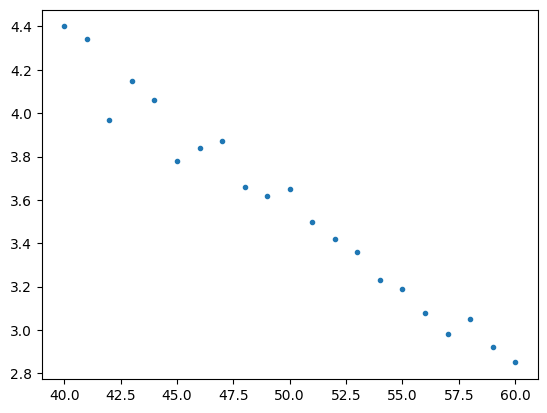

In [11]:
t3 = np.linspace(min(dist), max(dist), 100000)
plt.scatter(dist, amp3, marker=".")
plt.show()

In [12]:
# x = np.linspace(1,100, 10000)
# plt.plot(x, -x+50 +4*np.cos(x))

def modello_oscillante(x, A, B, C, D, E):
    return A*x + B + C*np.sin(D*x + E)

pars_osc_1, vals_osc_1, ers_osc_1, *other_osc_1 = LS_fit(dist, amp3, amp3_err, modello_oscillante, A=1, B=1, C=1, D=1, E=1)

for i in range(len(vals_osc_1)):
    print(f"Parametro {pars_osc_1[i]}: {vals_osc_1[i]:.3g} +- {ers_osc_1[i]:.3g}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 45.67 (χ²/ndof = 2.9)      │              Nfcn = 354              │
│ EDM = 1.02e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  -0.0745  │  0.0018   │            │            │         │         │       │
│ 1 │ B    │   7.29    │   0.09    │            │            │         │         │       │
│ 2 │ C    │   0.023   │   0.015   │            │            │         │         │       │
│ 3 │ D    │   1.00    │   0.07    │            │            │         │         │       │
│ 4 │ E    │     6     │     4     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────────────────────────────────┐
│   │          A          B          C          D          E │
├───┼────────────────────────────────────────────────────────┤
│ A │   3.37e-06  -168.6e-6    -1.9e-6    21.1e-6 -1.1641e-3 │
│ B │  -168.6e-6    0.00856    0.08e-3     -0.001      0.061 │
│ C │    -1.9e-6    0.08e-3   0.000239          0    0.36e-3 │
│ D │    21.1e-6     -0.001          0    0.00534     -0.267 │
│ E │ -1.1641e-3      0.061    0.36e-3     -0.267       13.9 │
└───┴────────────────────────────────────────────────────────┘

Parametro A: -0.0745 +- 0.00184
Parametro B: 7.29 +- 0.0925
Parametro C: 0.0227 +- 0.0155
Parametro D: 0.997 +- 0.073
Parametro E: 5.8 +- 3.72


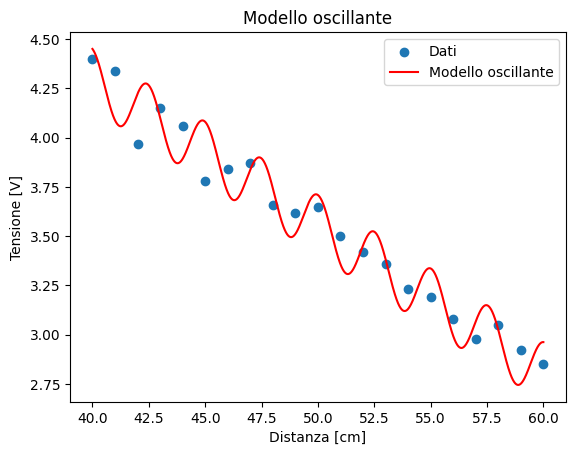

In [13]:
# plot dei risultati con valori modificati a mano

a_osc, b_osc, c_osc, d_osc , e_osc = vals_osc_1

plt.scatter(dist, amp3, label="Dati", marker="o")
plt.plot(t3, modello_oscillante(t3, a_osc, b_osc-.01, c_osc+.13, 1.5*d_osc+1, 2.5), label="Modello oscillante", color="red")
plt.xlabel("Distanza [cm]")
plt.ylabel("Tensione [V]")
plt.title("Modello oscillante")
plt.legend()
plt.show()

In [14]:
# tentativo di fit con modello 1/r

# ho provato un po' con questi modelli ma non funziona troppo
# def modello_1suR(x, A, T, omega, phi):
#     return (A*np.exp(-x/T)*np.cos(omega*x + phi))/x

# def modello_1suR_2(x, A, T, omega, phi):
#     return (A*np.exp(-x/T)*np.cos(omega*x + phi))/(x**2)

def mod_1suR(r, a, b):
    return a/r + b

pars1_1, vals1_1, ers1_1, *other1_1 = LS_fit(dist, amp3, amp3_err, mod_1suR, a=1, b=0)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 55.7 (χ²/ndof = 2.9)       │              Nfcn = 46               │
│ EDM = 2.97e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    179    │     4     │            │            │         │         │       │
│ 1 │ b    │   -0.07   │   0.09    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │      19  -0.386 │
│ b │  -0.386 0.00795 │
└───┴─────────────────┘

In [15]:
# modello 1/r^2

def mod_1suR2(r, a, b):
    return a/r**2 + b

pars1_2, vals1_2, ers1_2, *other1_2 = LS_fit(dist, amp3, amp3_err, mod_1suR2, a=1, b=0.5)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 74.1 (χ²/ndof = 3.9)       │              Nfcn = 45               │
│ EDM = 8.01e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  4.31e3   │  0.10e3   │            │            │         │         │       │
│ 1 │ b    │   1.76    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 1.11e+04  -4.6390 │
│ b │  -4.6390  0.00206 │
└───┴───────────────────┘

In [16]:
# modello combinato

def mod_comb(r, a, b, c):
    return a/r + b/r**2 + c

pars1_3, vals1_3, ers1_3, *other1_3 = LS_fit(dist, amp3, amp3_err, mod_comb, a=1, b=1, c=0)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 46.78 (χ²/ndof = 2.6)      │              Nfcn = 87               │
│ EDM = 1.29e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    420    │    80     │            │            │         │         │       │
│ 1 │ b    │  -5.8e3   │   1.9e3   │            │            │         │         │       │
│ 2 │ c    │   -2.5    │    0.8    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │ 6.38e+03   -154e3    -65.2 │
│ b │   -154e3 3.72e+06 1.5667e3 │
│ c │    -65.2 1.5667e3    0.667 │
└───┴────────────────────────────┘

In [17]:
# modello lineare

def mod_lin(r, a, b):
    return a*r + b

pars1_4, vals1_4, ers1_4, *other1_4 = LS_fit(dist, amp3, amp3_err, mod_lin, a=1, b=0)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 47.83 (χ²/ndof = 2.5)      │              Nfcn = 55               │
│ EDM = 2.25e-18 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -0.0743  │  0.0018   │            │            │         │         │       │
│ 1 │ b    │   7.28    │   0.09    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  3.25e-06 -162.3e-6 │
│ b │ -162.3e-6   0.00824 │
└───┴─────────────────────┘

In [18]:
# plot con le misure più fitte
# le misure oscillavano di meno

dist_prec = dati_distanza["distanza_precisa"].dropna()
amp3_prec = dati_distanza["tensione_precisa"].dropna()
amp3_prec_err = [0.02 for _ in amp3_prec]

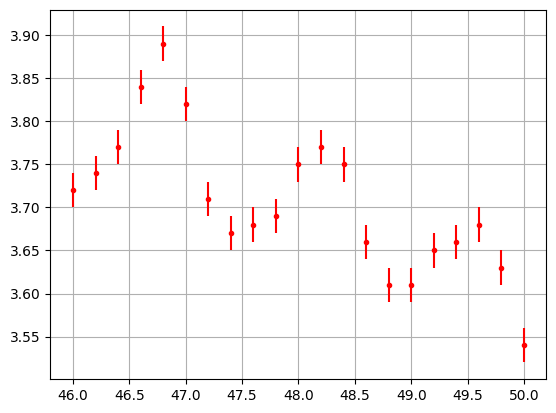

In [19]:
plt.errorbar(dist_prec, amp3_prec, amp3_prec_err, fmt=".r")
plt.grid()
plt.show()

In [20]:
# fit con modello oscillante

t4 = np.linspace(min(dist_prec), max(dist_prec), 100000)

pars_osc_2, vals_osc_2, ers_osc_2, *other_osc_2 = LS_fit(dist_prec, amp3_prec, amp3_prec_err, modello_oscillante, A=1, B=1, C=1, D=1)

RuntimeError: 4 values given for 5 function parameter(s)

**Commenti**

* non so davvero cosa farci

# ANGOLO DI BREWSTER

tensione senza polietilene $\approx$ 2.95 \
errore sulle x (gradi) = 2-3 \
indice rifrazione polietilene = 1.575

In [ ]:
#Raccolta dati per Brewster in trasmissione
dati_brewster_trasm = pd.read_excel("dati_brewster_trasm.xlsx")
gradi_br = dati_brewster_trasm["angolo"]
amp_br_tr_oriz = dati_brewster_trasm["tensione(oriz)"]
amp_br_tr_vert = dati_brewster_trasm["tensione(vert)"]
amp_br_tr_err = [0.03 for _ in amp_br_tr_vert]

#Raccolta dati per Brewster in riflessione
dati_brewster_rifl = pd.read_excel("dati_brewster_rifl.xlsx")
gradi_br_rifl = dati_brewster_rifl["angolo(specchio)"]
amp_br_rifl_oriz = dati_brewster_rifl["tensione(polar. oriz.)"]
amp_br_rifl_vert = dati_brewster_rifl["tensione(polar. vert.)"]
gradi_br_g1 = dati_brewster_rifl["angolo(specchio)(giorno1)"]
amp_br_rifl_g1 = dati_brewster_rifl["tensione(giorno1)"]
amp_br_rifl_err = [0.03 for _ in amp_br_rifl_vert]


#Diamo una stima di quanto dovrebbe uscire, conoscendo gli indici di rifrazione
indice_rifr1 = 1.00029
indice_rifr2 = 1.575
theta_br_atteso_rad = np.arctan(indice_rifr2/indice_rifr1)
theta_br_atteso_deg = np.rad2deg(theta_br_atteso_rad)
theta_br_atteso_err = 0
print(f"Theta atteso: {theta_br_atteso_deg :.2f}")

## Trasmissione

Per la trasmissione ci sono da escludere le misure dopo gli azzeramenti delle intensità: infatti dopo un certo angolo la tensione torna a crescere perchè il raggio dell'emettitore sorpassa la lastra senza effettuare il fenomeno che vogliamo

In [ ]:
N_misura_tras_oriz = 15

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].errorbar(gradi_br, amp_br_tr_oriz, amp_br_tr_err)
axs[0].grid()

axs[1].errorbar(gradi_br[:N_misura_tras_oriz], amp_br_tr_oriz[:N_misura_tras_oriz], amp_br_tr_err[:N_misura_tras_oriz])
axs[1].grid()

In [ ]:
def parabola_complete(x, a, b, c):
    return a*(x-b)**2 + c

first_point = 8
secnd_point = 14

dati_br_fit = amp_br_tr_oriz[first_point:secnd_point]
dati_br_fit_err = amp_br_tr_err[first_point:secnd_point]
gradi_br_fit = gradi_br[first_point:secnd_point]

pars2, vals2, ers2, *other2 = LS_fit(gradi_br_fit, dati_br_fit, dati_br_fit_err, parabola_complete, a=-1, b=57, c=0)

#test di compatibilità
comp_brew_1 = TestCompatibilita(vals2[1], ers2[1], theta_br_atteso_rad, theta_br_atteso_err)

#stampa dei risultati
print(f"Theta Brewster: {vals2[1]:.2f} +- {ers2[1]:.2f}")
print(f"Distanza in deviazioni standard: {comp_brew_1:.2f}")

per spiegare il picco iniziale, le onde vengono riflesse più volte, quindi leggiamo un segnale maggiore. \
per spiegare il picco finale, semplicemente parte delle onde raggiunge il ricevitore inimpedita, quindi non c'è perdita di segnale

In [ ]:
N_misura_tras_vert = 15

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(gradi_br, amp_br_tr_vert, amp_br_tr_err)
axes[0].grid()

axes[1].errorbar(gradi_br[:N_misura_tras_vert], amp_br_tr_vert[:N_misura_tras_vert], amp_br_tr_err[:N_misura_vert])
axes[1].grid()

## Riflessione

L'angolo lo abbiamo preso in base alla lastra di polietilene: ruotando la lastra, misuriamo l'angolo e spostiamo l'emettitore in modo da avere 180-2*$\theta$ (per la legge degli angoli o qualcosa) \
Ad esempio: se lo specchio è a 30°, l'emettitore sarà a 180°-60° = 120°

### Giornata 1

In [ ]:
N_misura_rifl_g1 = len(gradi_br_g1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].errorbar(gradi_br_g1, amp_br_rifl_g1, amp_br_rifl_err)
ax[0].grid()

ax[1].errorbar(gradi_br_g1[:N_misura_rifl_g1], amp_br_rifl_g1[:N_misura_rifl_g1], amp_br_rifl_err[:N_misura_rifl_g1])
ax[1].grid()

### Giornata 2

In [ ]:
N_misura_rifl_oriz = len(gradi_br_rifl)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].errorbar(gradi_br_rifl, amp_br_rifl_oriz, amp_br_rifl_err)
ax[0].grid()

ax[1].errorbar(gradi_br_rifl[:N_misura_rifl_oriz], amp_br_rifl_oriz[:N_misura_rifl_oriz], amp_br_rifl_err[:N_misura_rifl_oriz])
ax[1].grid()

In [ ]:
N_misura_rifl_vert = len(gradi_br_rifl)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].errorbar(gradi_br_rifl, amp_br_rifl_vert, amp_br_rifl_err)
ax[0].grid()

ax[1].errorbar(gradi_br_rifl[:N_misura_rifl_vert], amp_br_rifl_vert[:N_misura_rifl_vert], amp_br_rifl_err[:N_misura_rifl_vert])
ax[1].grid()

# DIFFRAZIONE DI BRAGG

La condizione di Bragg si verifica quando la differenza di cammino ottico tra i riflessi dai vari piani del cristallo da luogo a interferenza costruttiva:

n $\lambda$ = 2dsin $\theta$

lunghezza d'onda tabulata = 2.85cm

Piano parallelo utilizzato famiglia (100) quindi n = 1



Giorno 2 abbiamo preso ogni 2 gradi il cubo e di conseguenza 4 gradi il ricevitore 
a partire da 90 fino a 160



In [27]:
dati_bragg = pd.read_excel("dati_bragg.xlsx")
rad_bragg = np.deg2rad(dati_bragg["angolo(giorno2)"])
amp_bragg = dati_bragg["tensione(giorno2)"]
amp_bragg_err = [0.03 for i in amp_bragg]

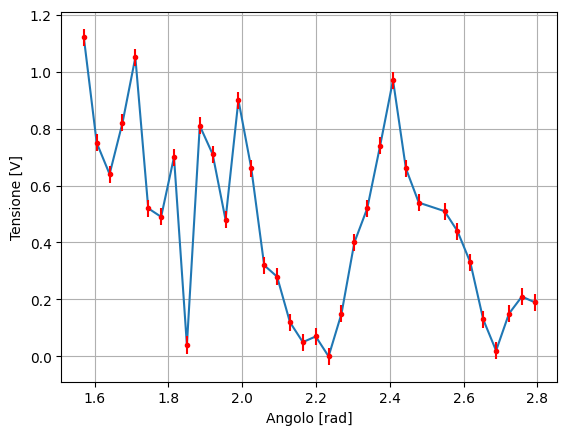

In [22]:
plt.plot(rad_bragg, amp_bragg)
plt.errorbar(rad_bragg, amp_bragg, amp_bragg_err, fmt=".r")
plt.xlabel("Angolo [rad]")
plt.ylabel("Tensione [V]")
plt.grid()
plt.show()
# I vari picchi strani del grafico rappresentano diffrazioni da vari piani oltre al nostro con indici 100

C:\Users\franc\AppData\Local\Temp\ipykernel_10516\1560743333.py:6: RuntimeWarning: invalid value encountered in arcsin
  return np.abs( np.sin(theta - np.arcsin(lambda_true / (2*d))))


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.073e+04 (χ²/ndof = 315.5)│              Nfcn = 108              │
│ EDM = 53.7 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ d    │  1.4398   │  0.0024   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        d │
├───┼──────────┤
│ d │ 5.57e-06 │
└───┴──────────┘

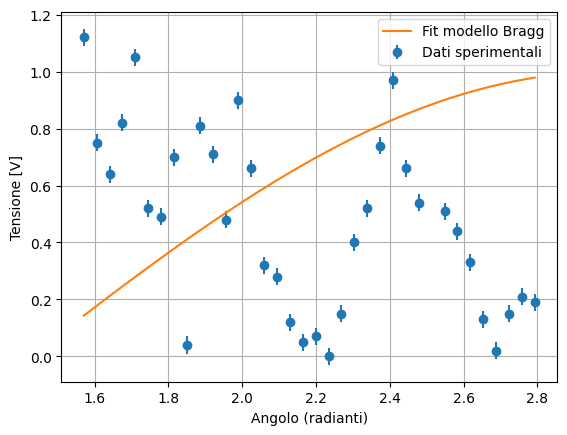

Stima di d: 1.44 +- 0.00236


In [59]:
#fit bragg
lambda_true = 2.85 


def modello_bragg(theta,d):
    return np.abs( np.sin(theta - np.arcsin(lambda_true / (2*d))))

params, vals, errs, pval, dof, chi_quadro, cov = LS_fit(rad_bragg, amp_bragg, amp_bragg_err, modello_bragg, d=1.5)

plt.errorbar(rad_bragg, amp_bragg, yerr=amp_bragg_err, fmt='o', label='Dati sperimentali')
theta_fit = np.linspace(min(rad_bragg), max(rad_bragg), 1000)
plt.plot(theta_fit, modello_bragg(theta_fit, vals[0]), label='Fit modello Bragg')
plt.xlabel('Angolo (radianti)')
plt.ylabel('Tensione [V]')
plt.grid()
plt.legend()
plt.show()

# Stima di d
d_best = vals[0]
d_err = errs[0]
print(f"Stima di d: {d_best:.3g} +- {d_err:.3g}")

In [60]:
#stima approssimativa con media dei picchi per d

angoli_picchi_deg = [90, 98, 104, 108, 114, 138]
angoli_picchi_rad = np.radians(angoli_picchi_deg)

lambda_microwave = 2.85  # cm

# Calcola d per ogni angolo di incidenza
d_values = []
for theta in angoli_picchi_rad:
    d = lambda_microwave / (2 * np.sin(theta))
    d_values.append(d)
    
d_media = np.mean(d_values)
d_std = np.std(d_values)
print(f"Distanza media tra i piani atomici d: {d_media:.2f} ± {d_std:.2f} cm")

Distanza media tra i piani atomici d: 1.59 ± 0.25 cm


# INTERFERENZA

## Michelson & Morley

**Posizioni iniziali** (distanze dal centro)
* emettitore = $26 \pm 0.3$ cm
* ricevitore = $28 \pm 0.3$ cm
* specchio b = $24.2 \pm 0.3$ cm
* specchio a (mobile) = $28.1 \pm 3$ cm --- segnato = 38.7 cm (sul metro)
* lunghezza del supporto = 4.5cm

Scheda lab chiede ricostruire:
* posizione massimi : li abbiamo effettivamente trovati ogni lambda/2 interf costrutt
* lambda : λ=2Δx/n
* intensità segnale funzione della distanza r (non abbiamo campionato abbastanza ogni frangia ma va bene cosi)


​
 

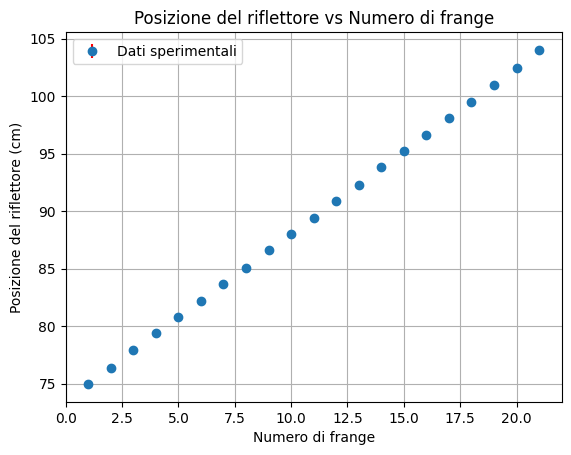

In [85]:
# minimi passati = 10
# errore sulle distanze = 0.2 cm
# errore sulle intensità = 0.02 V
x1 = 38.7
I1 = 0.82
x2 = 24.5
I2 = 0.87

x3 = 43.0
I3 = 1.1
x4 = 28.8
I4 = 0.83

x5 = 34.4
I5 = 0.83
x6 = 20.1
I6 = 0.86  

#Dati magici che mi ha dato babbo natale
frange = np.arange(1, 22)
posizioni = np.array([75.0, 76.4, 77.9, 79.4, 80.8, 82.2, 83.7, 85.1, 86.6, 88.0, 
                      89.4, 90.9, 92.3, 93.8, 95.2, 96.6, 98.1, 99.5, 101.0, 102.4, 104.0])
posizioni_err = [0.1 for i in posizioni]


plt.errorbar(frange, posizioni, yerr=posizioni_err, fmt='o', ecolor='r', label='Dati sperimentali')
plt.xlabel('Numero di frange')
plt.ylabel('Posizione del riflettore (cm)')
plt.title('Posizione del riflettore vs Numero di frange')
plt.grid()
plt.legend()
plt.show()


In [81]:
#stima lunghezza onda con frange vs posizione m sarà metà della lunghezza d'onda

def mod_lineare(x,m,q):
    return m*x +q

params, vals, errs, pval, dof, chi_quadro, cov = LS_fit(frange,posizioni,posizioni_err, mod_lineare, m=1,q=1)

m_best = vals[0]
m_err = errs[0]
print(f"Stima del coeff della retta è : {m_best:.3g} +- {m_err:.3g} ")
print(f"Quindi la lunghezza d'onda è: {2*m_best:.3g} +- {2*m_err:.3g} cm")


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.651 (χ²/ndof = 0.2)      │              Nfcn = 50               │
│ EDM = 8.29e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   1.444   │   0.004   │            │            │         │         │       │
│ 1 │ q    │   73.56   │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         m         q │
├───┼─────────────────────┤
│ m │   1.3e-05 -0.143e-3 │
│ q │ -0.143e-3   0.00205 │
└───┴─────────────────────┘

Stima del coeff della retta è : 1.44 +- 0.0036 
Quindi la lunghezza d'onda è: 2.89 +- 0.00721 cm


In [64]:
# Calcolo delle lunghezze d'onda 

mic_lambda_1 = (x1 - x2) / 10 * 2
mic_lambda_2 = (x3 - x4) / 10 * 2
mic_lambda_3 = (x5 - x6) / 10 * 2
#print(mic_lambda_1 , mic_lambda_2, mic_lambda_3)

mic_lambda_err = 0.2 
mic_sigma_lambda = np.sqrt(2 * (1/25)**2 * mic_lambda_err**2 ) # da formula della propagazione degli errori
mic_lambda_best = np.mean((mic_lambda_1, mic_lambda_2, mic_lambda_3))

print(f"Lambda best = {mic_lambda_best:.3g} +- {mic_sigma_lambda:.3g}")

Lambda best = 2.85 +- 0.0113


In [83]:
# test compatibilità

mic_lambda_comp = TestCompatibilita(mic_lambda_best, mic_sigma_lambda, 2.85, 0)
print(f"Test compatibilità lambda di Michelson: {mic_lambda_comp:.3g}")

Test compatibilità lambda di Michelson: 0.295


## Specchio di Lloyd

**Posizioni iniziali** (distanze dal centro)
* distanza specchio centro(shift) = $8 \pm 0.3$ cm
Per specchio di Lloyd abbiamo preso la distanza tra ricevitore ed emettitore reale, tra il punto di emissione e quello di ricezione.
* supporto-ricevitore = $5.5 \pm 0.3$ cm
* supporto-emettitore = $2.5 \pm 0.3$ cm
* Distanza12 emissione-ricezione = $100 \pm 1$ cm
* Distanza34 emissione-ricezione = $110 \pm 1$ cm


In [ ]:
#Misure prese con specchio sottile
#h1 = 10.4
#v1 = 1.74
#h2 = 16.7
#v2 = 1.74
#Le misure h sono prese in cm, le misure in v sono prese in volt
#Incertezza lunghezza: 0.2 cm, Incertezza intensità: 0.03 volt
h_err = 0.2
v_err = 0.03

# prima misurazione
d12 = 100
d12_err = 1

h1 = 9.9
v1 = 1.64
h2 = 16.9
v2 = 1.7

# seconda misurazione
d34 = 110
d34_err = 1

h3 = 10.9
v4 = 1.40
h4 = 17.2
v4 = 1.5


In [ ]:
# calcolo n, il numero del minimo per tutte le misurazioni, dato che per ottenere lambda serve n

n_1 = lloyd_n_frangia(d12, h1)
n_2 = lloyd_n_frangia(d12, h2)
n_3 = lloyd_n_frangia(d34, h3)
n_4 = lloyd_n_frangia(d34, h4)

#calcolo lambda per ogni misurazione
lambda_1 = lloyd(d12, h1, n_1)
lambda_2 = lloyd(d12, h2, n_2)
lambda_3 = lloyd(d34, h3, n_3)
lambda_4 = lloyd(d34, h4, n_4)

#calcolo errore su lambda
lambda_1_err = (np.sqrt(((2*d12 + 2*np.sqrt(4*h1**2 + d12**2))*d12_err)**2 + (8*h1*h_err)**2))/(n_1*np.sqrt(4*h1**2 + d12**2))
lambda_2_err = (np.sqrt(((2*d12 + 2*np.sqrt(4*h2**2 + d12**2))*d12_err)**2 + (8*h2*h_err)**2))/(n_2*np.sqrt(4*h2**2 + d12**2))
lambda_3_err = (np.sqrt(((2*d34 + 2*np.sqrt(4*h3**2 + d34**2))*d34_err)**2 + (8*h3*h_err)**2))/(n_3*np.sqrt(4*h3**2 + d34**2))
lambda_4_err = (np.sqrt(((2*d34 + 2*np.sqrt(4*h4**2 + d34**2))*d34_err)**2 + (8*h4*h_err)**2))/(n_4*np.sqrt(4*h4**2 + d34**2))


#stampo i risultati
print(f"Lambda 1 = {lambda_1:.3g} +- {lambda_1_err:.1g}")
print(f"Lambda 2 = {lambda_2:.3g} +- {lambda_2_err:.1g}")
print(f"Lambda 3 = {lambda_3:.3g} +- {lambda_3_err:.1g}")
print(f"Lambda 4 = {lambda_4:.3g} +- {lambda_4_err:.1g}")

# test compatibilità
comp_1 = TestCompatibilita(lambda_1, lambda_1_err, 2.85, 0)
comp_2 = TestCompatibilita(lambda_2, lambda_2_err, 2.85, 0)
comp_3 = TestCompatibilita(lambda_3, lambda_3_err, 2.85, 0)
comp_4 = TestCompatibilita(lambda_4, lambda_4_err, 2.85, 0)

print(f"Distanza in deviazioni standard per lambda 1: {comp_1:.3g}")
print(f"Distanza in deviazioni standard per lambda 2: {comp_2:.3g}")
print(f"Distanza in deviazioni standard per lambda 3: {comp_3:.3g}")
print(f"Distanza in deviazioni standard per lambda 4: {comp_4:.3g}")
